In [3]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
sns.set(color_codes=True)
%matplotlib inline
matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
})


In [48]:

runs = MlflowClient(tracking_uri="file:/data/logs/kristian/mlruns").search_runs(
  experiment_ids="33",
  # filter_string="tags.type = 'pruning + quantization'",
)


In [49]:
data = np.zeros((8,9))
for run in runs:
    acc = run.data.metrics["q_test/acc"]
    ap = int(run.data.params["quantization/activation_precision"])
    wp = int(run.data.params["quantization/weight_precision"])
    data[ap, wp] = acc



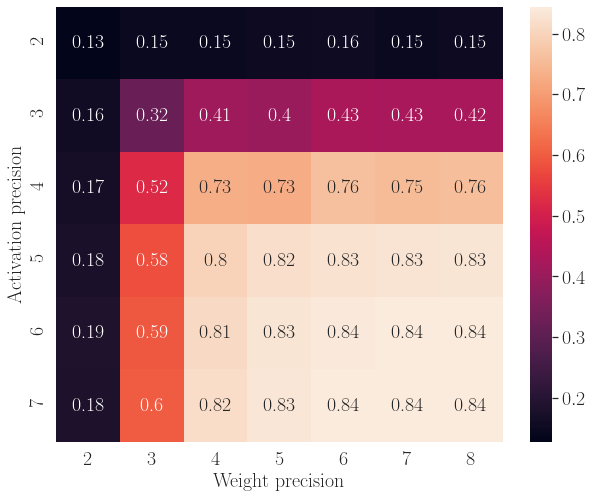

In [50]:
fig, ax = plt.subplots(figsize=(10,8))
fig = sns.heatmap(data[2:, 2:], annot=True, xticklabels=[2, 3, 4, 5, 6, 7, 8],
                  yticklabels=[2, 3, 4, 5, 6, 7], annot_kws={"size": 20})
plt.xlabel("Weight precision", fontsize=20)
plt.ylabel("Activation precision", fontsize=20)
fig.tick_params(labelsize=20)
cbar = ax.collections[0].colorbar
# here set the labelsize by 20
cbar.ax.tick_params(labelsize=20)

# plt.show(fig)

plt.savefig('/home/k.schwienbacher/quantization-robustness/data/squeeze-q.pdf', bbox_inches="tight")


In [4]:
experiments = [
    # {'id': "3", 'train_id': "3", 'name': 'pruned-resnet18' },
    # {'id': "10", 'train_id': "3", 'name': 'resnet18' },

    #{'id': "7", 'train_id': "7", 'name': 'pruned-lenet' },
    #{'id': "7", 'train_id': "7", 'name': 'lenet' },

    #{'id': "11", 'name': 'lenetplus' },
    #{'id': "11", 'name': 'pruned-lenetplus' },

    #{'id': "8", 'train_id': "8", 'name': 'pruned-squeezenet' },
    #{'id': "14", 'train_id': "8", 'name': 'squeezenet' },
    {'id': "24", 'name': 'lenet'},
    {'id': "27", 'name': 'resnet18'},
    {'id': "26", 'name': 'squeezenet'},
    {'id': "25", 'name': 'lenetplus'}
]


In [5]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []


for exp in experiments:
  df_runs = mlflow.search_runs(
    experiment_ids=exp['id'],
    filter_string="tags.stage = 'eval' and tags.type = 'pruning + quantization'" if exp['name'].startswith("pruned") else "tags.stage = 'eval' and tags.type = 'quantization'",
    output_format="pandas"
  )
  # fp_runs = mlflow.search_runs(
  #   experiment_ids=exp["train_id"] if "train_id" in exp.keys() else exp['id'],
  #   filter_string="tags.stage = 'train'",
  #   output_format="pandas",
  #   max_results=1,
  # ) 
  # fp_runs["params.quantization/weight_precision"] = 'fp'
  # fp_runs["metrics.q_test/acc"] = fp_runs["metrics.test/acc"]
  # fp_runs = fp_runs.set_index("params.quantization/weight_precision")

  run = df_runs[df_runs["params.quantization/activation_precision"] == '7'].set_index("params.quantization/weight_precision")
  # run = run.append(fp_runs.iloc[0])
  run.sort_index(inplace=True, ascending=False)

  run['name'] = exp['name']
  runs.append((exp['name'], run))


In [13]:
df = pd.DataFrame()
for name, run in runs:
    df[name] = run["metrics.q_gaussian_blur_1_test/acc"]

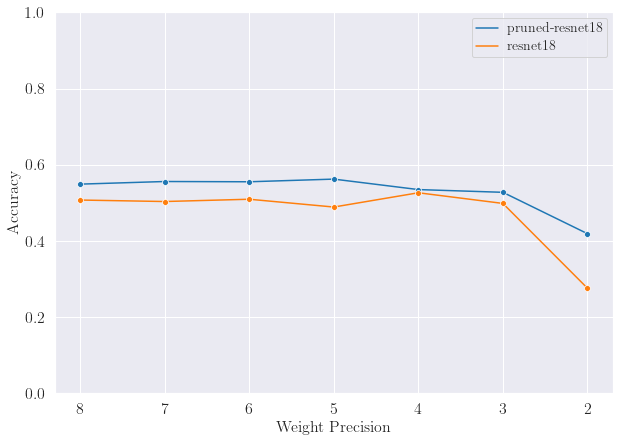

In [14]:
fig, ax = plt.subplots(figsize=(10,7))
sns.set_palette("tab10")
grid = sns.lineplot(data=df, dashes=False, marker="o")
plt.ylim(0, 1)

grid.set_xlabel("Weight Precision", fontsize=16)
grid.set_ylabel("Accuracy", fontsize=16)
grid.tick_params(labelsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.setp(ax.get_legend().get_texts(), fontsize=14)

plt.savefig('/home/k.schwienbacher/quantization-robustness/data/quant-acc-gb1.pdf')


In [11]:
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")
runs = []


for exp in experiments:
  df_runs = mlflow.search_runs(
    experiment_ids=exp['id'],
    filter_string="tags.stage = 'eval' and tags.type = 'quantization'",
    output_format="pandas"
  )
  fp_runs = mlflow.search_runs(
    experiment_ids=exp["train_id"] if "train_id" in exp.keys() else exp['id'],
    filter_string="tags.stage = 'train'",
    output_format="pandas",
    max_results=1,
  )l
  o
  fp_runs["params.quantization/activation_precision"] = 'fp'
  fp_runs["metrics.q_test/acc"] = fp_runs["metrics.test/acc"]
  fp_runs = fp_runs.set_index("params.quantization/activation_precision")

  run = df_runs[df_runs["params.quantization/weight_precision"] == '8'].set_index("params.quantization/activation_precision")
  run = run.append(fp_runs.iloc[0])
  run.sort_index(inplace=True, ascending=False)

  run['name'] = exp['name']
  runs.append((exp['name'], run))



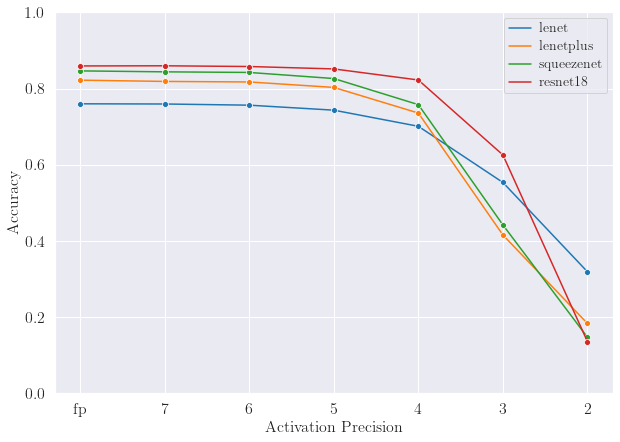

In [16]:
df = pd.DataFrame()
for name, run in runs:
    df[name] = run["metrics.q_test/acc"]

fig, ax = plt.subplots(figsize=(10, 7))
sns.set_palette("tab10")
grid = sns.lineplot(data=df, dashes=False, marker="o")
plt.ylim(0, 1)

grid.set_xlabel("Activation Precision", fontsize=16)
grid.set_ylabel("Accuracy", fontsize=16)
grid.tick_params(labelsize=16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
plt.setp(ax.get_legend().get_texts(), fontsize=14)

plt.savefig('/home/k.schwienbacher/quantization-robustness/data/quant-acc-act.pdf')
